# 1. Step: Import of required libraries

In this step all the libraries needed within the script are imported

In [1]:
import sys
import xlrd, xlsxwriter
import numpy as np
import pandas as pd
import time
import datetime
import scipy.io
import scipy

# 2. Step: Locating the Database Address

The database address is defined in this step.

In [2]:
ProjectSpecs_Path_Main     = 'C:/Users/ghardadi/Documents/'
ProjectSpecs_Name_ConFile  = 'MRIO_Config.xlsx'
ProjectSpecs_DataPath1     = 'C:/Users/ghardadi/EXIOBASE_2/'
ProjectSpecs_PackagePath1  = 'C:/Users/ghardadi/'

sys.path.append(ProjectSpecs_PackagePath1)

# 3. Step: Extracting the Information from Config File

In this step we collect the information from config file and start the simulation.

In [3]:
# Load project-specific config file
Project_Configfile  = xlrd.open_workbook(ProjectSpecs_Path_Main + 'Calculation/' + ProjectSpecs_Name_ConFile)
Project_Configsheet = Project_Configfile.sheet_by_name('Config')

# Naming script and defining of name specifications (e.g. date when the script was used)
Name_Script        = Project_Configsheet.cell_value(6,3)
Name_Scenario      = Project_Configsheet.cell_value(5,3)
StartTime          = datetime.datetime.now()
TimeString         = str(StartTime.year) + '_' + str(StartTime.month) + '_' + str(StartTime.day) + '__' + str(StartTime.hour) + '_' + str(StartTime.minute) + '_' + str(StartTime.second)
DateString         = str(StartTime.year) + '_' + str(StartTime.month) + '_' + str(StartTime.day)
Path_Result        = ProjectSpecs_Path_Main + 'Results/'

# Importing information about Exiobase 2.2 from excel file
EB3_NoofCountries  = int(Project_Configsheet.cell_value(4,8))
EB3_NoofProducts   = int(Project_Configsheet.cell_value(5,8))
EB3_NoofIndustries = int(Project_Configsheet.cell_value(6,8))
EB3_NoofIOSectors  = int(Project_Configsheet.cell_value(7,8))
EB3_NoofFDCategories = int(Project_Configsheet.cell_value(8,8))

# Start the timer
Time_Start = time.time()
print('Start of simulation: ' + time.asctime() + '.')

Start of simulation: Tue Feb  4 09:20:09 2020.


# 4. Step: Import Exiobase 3.6

Now, Exiobase 3.6 will be imported. This includes the following:

L-Matrix containing the Leontief-Inverse

S-Matrix containing the emissions

Y-Matrix containing the final demands

FDE-Matrix containing the direct emissions caused by the final demands

In [4]:
print('Loading Exiobase 3.6 data.')

MRIO_Name = 'EXIOBASE3_13_Mon_49R_2018_06_01_ITCpxp.mat'

Filestring_Matlab_in = ProjectSpecs_DataPath1 + MRIO_Name

print('Import L-Matrix (Leontief-Inverse)')
MRIO_L = scipy.io.loadmat(Filestring_Matlab_in)['EB3_L_ITC']

print('Import S-Matrix (Emissions).')
MRIO_S = scipy.io.loadmat(Filestring_Matlab_in)['EB3_S_ITC']

print('Import Y-Matrix (Final Demands)')
MRIO_Y = scipy.io.loadmat(Filestring_Matlab_in)['EB3_Y']

print('Import FDE-Matrix (Direct Emissions from Final Demand).')
MRIO_FDE = scipy.io.loadmat(Filestring_Matlab_in)['EB3_FinalDemand_Emissions']

print('Import the Names of Industry Sectors.')
MRIO_Prod = scipy.io.loadmat(Filestring_Matlab_in)['EB3_ProductNames200']

print('Import the Names of Extension Codes.')
MRIO_Ext = scipy.io.loadmat(Filestring_Matlab_in)['EB3_Extensions']

print('Import the Names of Regions.')
MRIO_Reg = scipy.io.loadmat(Filestring_Matlab_in)['EB3_RegionList']

Loading Exiobase 3.6 data.
Import L-Matrix (Leontief-Inverse)
Import S-Matrix (Emissions).
Import Y-Matrix (Final Demands)
Import FDE-Matrix (Direct Emissions from Final Demand).
Import the Names of Industry Sectors.
Import the Names of Extension Codes.
Import the Names of Regions.


### Importing population data

In [5]:
Region_Datasheet = Project_Configfile.sheet_by_name('EXIOBASE 3 countries')

Region_Names = []
for m in range(0,49):
    Region_Names.append(Region_Datasheet.cell_value(m+4,5))
    
Population = []
for m in range(0,49):
    Population.append(int(Region_Datasheet.cell_value(m+4,12)))

print(Region_Names)
print()
print(Population)

['Austria', 'Belgium', 'Bulgaria', 'Cyprus', 'Czech Republic', 'Germany', 'Denmark', 'Estonia', 'Spain', 'Finland', 'France', 'Greece', 'Croatia', 'Hungary', 'Ireland', 'Italy', 'Lithuania', 'Luxembourg', 'Latvia', 'Malta', 'Netherlands', 'Poland', 'Portugal', 'Romania', 'Sweden', 'Slovenia', 'Slovakia', 'United Kingdom', 'United States', 'Japan', 'China', 'Canada', 'South Korea', 'Brazil', 'India', 'Mexico', 'Russia', 'Australia', 'Switzerland', 'Turkey', 'Taiwan', 'Norway', 'Indonesia', 'South Africa', 'RoW Asia and Pacific', 'RoW America', 'RoW Europe', 'RoW Africa', 'RoW Middle East']

[8479823, 11159407, 7265115, 1143866, 10334160, 80645605, 5461438, 1317997, 46620045, 5288720, 65998687, 10965211, 4255689, 9893082, 4623816, 60233948, 2957689, 543360, 2012647, 425967, 16804432, 38040196, 10457295, 19983693, 9600379, 2059953, 5413393, 64128226, 316057727, 127445000, 1357380000, 35082954, 50428893, 201035903, 1280846129, 118827161, 143506911, 23128129, 8089346, 75928564, 23374000, 50

# 5. Step: Import characterisation factors

In order to calculate the environmental footprints, characterisation factors are needed
to convert the emissions received by S. L. Y to midpoint indicators

In [6]:
print('Import characterisation factors to calculate midpoint indicators.')

ImpactFile  = xlrd.open_workbook(ProjectSpecs_DataPath1 + 'Characterization_EB36.xlsx')
ImpactSheet = ImpactFile.sheet_by_name('Emissions')
ImpactCategory_Names = []
for m in range(0,36):
    ImpactCategory_Names.append(ImpactSheet.cell_value(0,m))
    
MRIO_Char = np.zeros((36,1707))
for m in range(0,36):
    for n in range(0,1707):
        MRIO_Char[m,n] = ImpactSheet.cell_value(n+1,m+1)

Import characterisation factors to calculate midpoint indicators.


# 6. Step: Selecting the final demand vectors

The Y vector is selected based on the environmental footprints that is going to be assessed. The demand emissions are also added in the footprint calculation. The environmental footprint assessed in this study is Carbon Footprint of German households.

In [7]:
print('Selecting the final demand vectors.')

FD_DE_HH = MRIO_Y[:,EB3_NoofFDCategories*5]
DE_DE_HH = MRIO_FDE[:,EB3_NoofFDCategories*5]

Selecting the final demand vectors.


In [8]:
EB3_NoofFDCategories

7

# 7. Step: Import aggregation table

In order to aggregate the environmental footprints based on consumed products, producing sectors and regions, aggregation table is needed to aggregate the detailed information of emissions into a set of aggregated sections.

In [9]:
print('Import Excel file containing aggregation table.')
# Excel file created by Gilang Hardadi based on the excel file named
# EB340_Aggregation.xlsx
AggregationFile  = xlrd.open_workbook(ProjectSpecs_DataPath1 + 'EB340_Aggregation.xlsx')

# 1) Product aggregation
ProductSheet = AggregationFile.sheet_by_name('Products')
PI = [] # Names of categories
Pv = [] # List of aggregation indices
Pa = [] # Names of aggregated categories
for m in range(0,200):
    PI.append(ProductSheet.cell_value(m+1,0))
for m in range(0,200):
    Pv.append(int(ProductSheet.cell_value(m+1,1)))
for m in range(0,12):
    Pa.append(ProductSheet.cell_value(m+1,3))


Import Excel file containing aggregation table.


In [10]:
print(PI)
print(Pv)
print(Pa)

['Paddy rice', 'Wheat', 'Cereal grains nec', 'Vegetables, fruit, nuts', 'Oil seeds', 'Sugar cane, sugar beet', 'Plant-based fibers', 'Crops nec', 'Cattle', 'Pigs', 'Poultry', 'Meat animals nec', 'Animal products nec', 'Raw milk', 'Wool, silk-worm cocoons', 'Manure (conventional treatment)', 'Manure (biogas treatment)', 'Products of forestry, logging and related services', 'Fish and other fishing products; services incidental of fishing', 'Anthracite', 'Coking Coal', 'Other Bituminous Coal', 'Sub-Bituminous Coal', 'Patent Fuel', 'Lignite/Brown Coal', 'BKB/Peat Briquettes', 'Peat', 'Crude petroleum and services related to crude oil extraction, excluding surveying', 'Natural gas and services related to natural gas extraction, excluding surveying', 'Natural Gas Liquids', 'Other Hydrocarbons', 'Uranium and thorium ores', 'Iron ores', 'Copper ores and concentrates', 'Nickel ores and concentrates', 'Aluminium ores and concentrates', 'Precious metal ores and concentrates', 'Lead, zinc and tin 

# 8. Step: Calculating the emissions inventory and footprint

The inventories enlist the emissions embodied in the household consumption for each emissions type.
The footprint will show the total GHG emissions, measured in CO<sub>2</sub> equivalent.

$$\sum Footprint_i = C \times (S. L. Y_i)$$

In [13]:
Ind_DE_HH = MRIO_S.dot(MRIO_L).dot(np.diag(FD_DE_HH))

# Creating new matrix to save Footprint data
Footprint = np.zeros(9800)

for n in range(0,9800):
    Footprint[n] = (MRIO_Char[4,:] * Ind_DE_HH[:,n]).sum(axis=0)

Footprint = np.reshape(Footprint, (49,200))
Footprint = Footprint.sum(axis=0)

DEm_DE_HH = (MRIO_Char[4,:] * DE_DE_HH).sum(axis=0)

In [21]:
round((Footprint.sum(axis=0) + DEm_DE_HH)/1e9, 2)

762.98

In [18]:
Footprint.shape

(200,)

In [12]:
np.diag(FD_DE_HH).shape

(9800, 9800)

In [19]:
Footprint = np.append(Footprint, DEm_DE_HH)

PI.append('Direct Emissions')
pd.DataFrame(np.round(Footprint/1e9,3), index=PI, columns=["GHG Emissions, million ton CO2e"])

,"GHG Emissions, million ton CO2e"
Paddy rice,0.026
Wheat,1.712
Cereal grains nec,0.385
"Vegetables, fruit, nuts",5.961
Oil seeds,1.092
...,...
"Recreational, cultural and sporting services",5.778
Other services,6.876
Private households with employed persons,0.034
Extra-territorial organizations and bodies,0.000


# 9. Step: Aggregating the result

Aggregating the Carbon Footprint Result

In [26]:
Footprint = Footprint[0:200]
PI = PI[0:200]

In [22]:
def MI_Tuple(value, Is): 
    """
    Define function for obtaining multiindex tuple from index value
    value: flattened index position, Is: Number of values for each index dimension
    Example: MI_Tuple(10, [3,4,2,6]) returns [0,0,1,4]
    MI_Tuple(138, [100,10,5]) returns [2,7,3]
    MI_Tuple is the inverse of Tuple_MI.
    """
    IsValuesRev = []
    CurrentValue = value
    for m in range(0,len(Is)):
        IsValuesRev.append(CurrentValue % Is[len(Is)-m-1])
        CurrentValue = CurrentValue // Is[len(Is)-m-1]
    return IsValuesRev[::-1]    

def Tuple_MI(Tuple, IdxLength): 
    """
    Function to return the absolution position of a multiindex when the index tuple
    and the index hierarchy and size are given.
    Example: Tuple_MI([2,7,3],[100,10,5]) returns 138
    Tuple_MI([0,0,1,4],[3,4,2,6]) returns 10
    Tuple_MI is the inverse of MI_Tuple.
    """
    # First, generate the index position offset values
    IdxShift =  IdxLength[1:] +  IdxLength[:1] # Shift 1 to left
    IdxShift[-1] = 1 # Replace lowest index by 1
    IdxShift.reverse()
    IdxPosOffset = np.cumproduct(IdxShift).tolist()
    IdxPosOffset.reverse()
    Position = np.sum([a*b for a,b in zip(Tuple,IdxPosOffset)])
    return Position

def build_Aggregation_Matrix(Position_Vector): # from PySUT
    """Turn a vector of target positions into a matrix that aggregates 
    or re-arranges rows of the table it is multiplied to from the left 
    (or columns, if multiplied transposed from the right)"""
    AM_length = Position_Vector.max() + 1 # Maximum row number of new matrix (+1 to get the right length, as 0 is the smallest target position entry.)
    AM_width  = len(Position_Vector) # Number of rows of the to-be-aggregated matrix
    Rearrange_Matrix = np.zeros((AM_length,AM_width))
    for m in range(0,len(Position_Vector)):
        Rearrange_Matrix[Position_Vector[m].item(0),m] = 1 # place 1 in aggregation matrix at [PositionVector[m],m], so that column m is aggregated with Positionvector[m] in the aggregated matrix
    return Rearrange_Matrix

def build_MultiIndex_Aggregation_Matrix(Position_Vectors):
    """Turn a list of vectors of target positions that represent aggregations of the different levels of a multi-index of a table into a matrix that aggregates 
    or re-arranges rows of the multiindex table it is multiplied to from the left 
    (or columns, if multiplied transposed from the right)"""   
    OldLength = [len(i)    for i in Position_Vectors]
    NewLength = [max(i) +1 for i in Position_Vectors]
    Rearrange_Matrix = np.zeros((np.product(NewLength),np.product(OldLength)))
    for m in range(0,np.product(OldLength)):
        OldIndexTuple = MI_Tuple(m,OldLength) # convert running index to tuple (column index)
        NewIndexTuple = [Position_Vectors[i][OldIndexTuple[i]] for i in range(0,len(OldIndexTuple))] # convert unaggregated tuple to aggregated tuple
        NewIndexPos   = Tuple_MI(NewIndexTuple, NewLength)# Calculate new running index (row index)
        Rearrange_Matrix[NewIndexPos,m] = 1 # Aggregate/resort row m into row NewIndexPos.
    return Rearrange_Matrix

In [24]:
Aggregation_Matrix_Cols = build_MultiIndex_Aggregation_Matrix([np.zeros((49),dtype = 'int').tolist(),Pv])

pd.DataFrame(Aggregation_Matrix_Cols)

,0,1,2,3,4,5,6,7,8,9,...,9790,9791,9792,9793,9794,9795,9796,9797,9798,9799
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0
8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0
9,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [27]:
Indirect_DE_HH = MRIO_Char[4,:].dot(MRIO_S).dot(MRIO_L).dot(np.diag(FD_DE_HH))

Indirect_DE_HH = Indirect_DE_HH.dot(Aggregation_Matrix_Cols.transpose())

Pa = Pa[0:12]
Pa.extend(['Direct Emissions'])

Footprint_Carbon = Indirect_DE_HH.copy()

# Determine and add direct indicator:
Direct_GHG = MRIO_Char[4,:].dot(MRIO_FDE[:,35])

Footprint_Carbon = np.append(Footprint_Carbon, [Direct_GHG])

CF_PerCapita = Footprint_Carbon/Population[5]

pd.DataFrame(np.round(CF_PerCapita,2), index=Pa, columns=["kg CO2e"])

,kg CO2e
Air Transportation,366.96
Animal-based Food,1009.98
Clothing and Footwear,481.25
Heating and Utilities,494.61
"Hotel, Restaurant, and Recreation",256.08
Household Electricity,723.32
Household Goods,1045.44
Housing and Material,705.22
Other Services,494.04
Public Transportation,84.40


In [28]:
CF_PerCapita = np.zeros((13,49)) #49 is the number of regions, could be changed into less amount of regions

for n in range(0,49):
    Indirect_HH = MRIO_Char[4,:].dot(MRIO_S).dot(MRIO_L).dot(np.diag(MRIO_Y[:,7*n+3]))
    Indirect_HH = Indirect_HH.dot(Aggregation_Matrix_Cols.transpose())
    Footprint_Carbon = Indirect_HH.copy()

    # Determine and add direct indicator:
    Direct_GHG = MRIO_Char[4,:].dot(MRIO_FDE[:,7*n]) 
    Footprint_Carbon = np.append(Footprint_Carbon, [Direct_GHG])
    CF_PerCapita[:,n] = Footprint_Carbon/Population[n]

CF_PerCapita = pd.DataFrame(np.round(CF_PerCapita,2), index=Pa, columns=Region_Names)

In [29]:
Parr = ["Animal-based Food", "Vegetable-based Food", "Clothing and Footwear",
        "Housing and Material", "Household Electricity", "Heating and Utilities",
        "Public Transportation", "Private Transportation", "Air Transportation",
        "Household Goods", "Hotel, Restaurant, and Recreation", "Other Services",
        "Direct Emissions"]

Color1 = ["#E61709", "#E2792E", "#FDB515", "#FF8C00", "#6B8E23", "#61BD5C",
          "#0072CC", "#75B2DD", "#BA55D3", "#C0C0C0", "#A65628", "#DEB887", "#696969"]

In [32]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

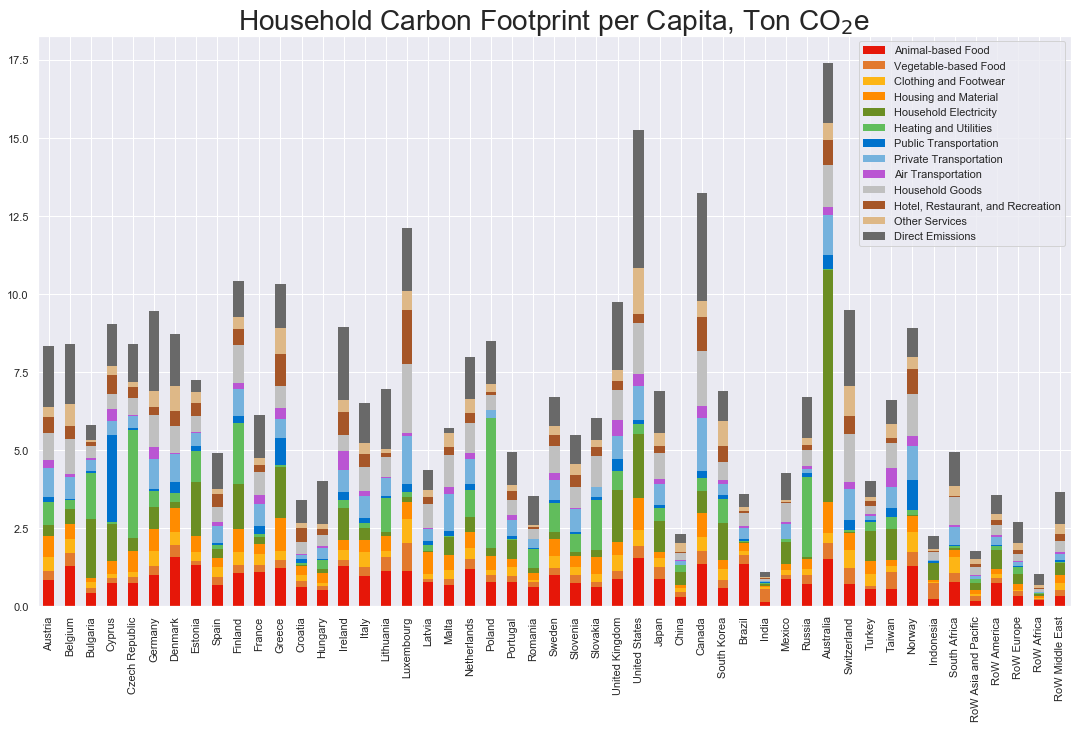

In [33]:
CF_PerCapita = CF_PerCapita.reindex(Parr)

CF_Graph = CF_PerCapita.transpose()/1e3
CF_Graph.plot(kind='bar', stacked=True, figsize=(18.5, 10.5), linewidth = 0,
              color = Color1)
plt.title(r'Household Carbon Footprint per Capita, Ton CO$_2$e', size=28)
plt.show()

In [34]:
CF_PerCapita = np.zeros((13,49)) #49 is the number of regions, could be changed into less amount of regions

for n in range(0,49):
    Indirect_GFCF = MRIO_Char[4,:].dot(MRIO_S).dot(MRIO_L).dot(np.diag(MRIO_Y[:,7*n+3]))
    Indirect_GFCF = Indirect_GFCF.dot(Aggregation_Matrix_Cols.transpose())
    Footprint_Carbon = Indirect_GFCF.copy()

    # Determine and add direct indicator:
    Direct_GHG = MRIO_Char[4,:].dot(MRIO_FDE[:,7*n+3]) 
    Footprint_Carbon = np.append(Footprint_Carbon, [Direct_GHG])
    CF_PerCapita[:,n] = Footprint_Carbon/Population[n]

CF_PerCapita = pd.DataFrame(np.round(CF_PerCapita,2), index=Pa, columns=Region_Names)

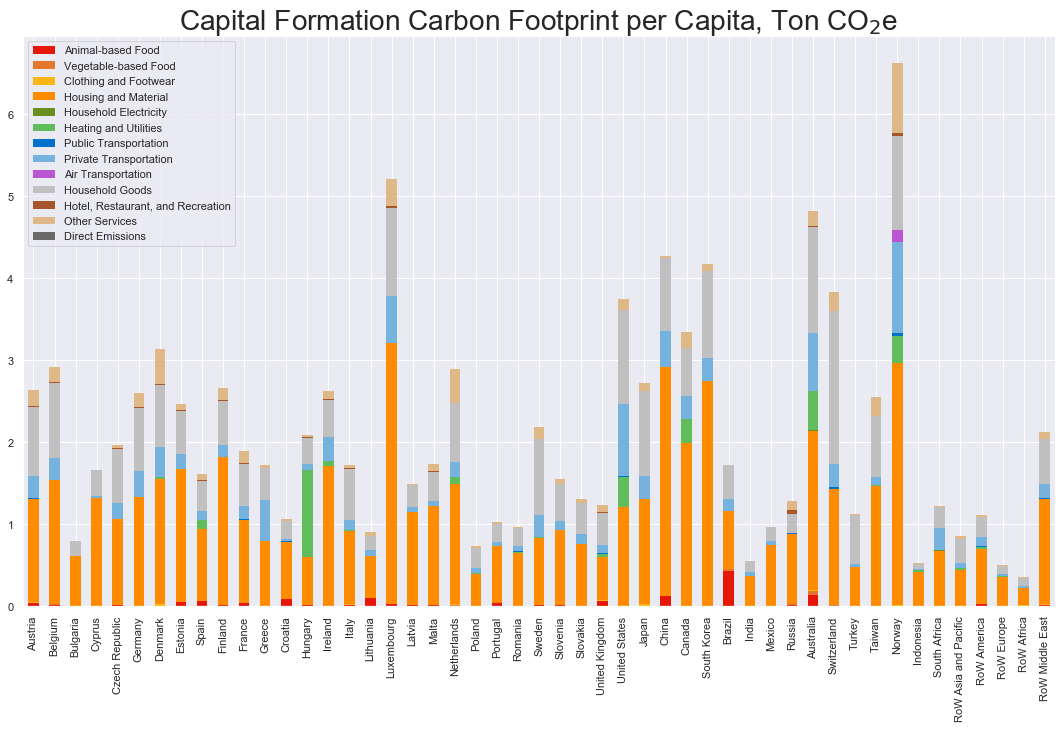

In [36]:
CF_PerCapita = CF_PerCapita.reindex(Parr)

CF_Graph = CF_PerCapita.transpose()/1e3
CF_Graph.plot(kind='bar', stacked=True, figsize=(18.5, 10.5), linewidth = 0,
              color = Color1)
plt.title(r'Capital Formation Carbon Footprint per Capita, Ton CO$_2$e', size=28)
plt.show()

### Adding Direct Emissions Share Data

In [37]:
print('Import Excel file containing direct emissions data (EU countries only).')
# Excel file obtained from Eurostat based on the excel file named
# DirectEmissions_2013.xlsx
DirectEmissionsFile = xlrd.open_workbook(ProjectSpecs_DataPath1 + 'DirectEmissions_2013.xlsx')

# 1) Product aggregation
DirectEmissionsSheet = DirectEmissionsFile.sheet_by_name('Percent')
GHGHeating = [] # Names of categories
GHGTransport = [] # List of aggregation indices
GHGOthers = [] # Names of aggregated categories
for m in range(0,49):
    GHGHeating.append(DirectEmissionsSheet.cell_value(m+12,2))
for m in range(0,49):
    GHGTransport.append(DirectEmissionsSheet.cell_value(m+12,3))
for m in range(0,49):
    GHGOthers.append(DirectEmissionsSheet.cell_value(m+12,4))

Import Excel file containing direct emissions data (EU countries only).


In [38]:
GHGHeating

[0.4582241467418895,
 0.5595934697186867,
 0.14173003559876893,
 0.1923707859677789,
 0.7586642403935022,
 0.4966460996854874,
 0.3082845184814175,
 0.3251879518813863,
 0.26431719833873785,
 0.21928341608403104,
 0.4341809709905608,
 0.25019659146008927,
 0.2760598511405909,
 0.5572827333082885,
 0.48821333657130883,
 0.4797478992114969,
 0.2553007564819998,
 0.6514106896777793,
 0.24282667575898925,
 0.10969595819745394,
 0.5503489517972754,
 0.7668931541090832,
 0.0,
 0.3379618206540136,
 0.05803630510311522,
 0.26090305623223975,
 0.5791918198406618,
 0.5405589526044706,
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 0.5049311707222971,
 0.40979677938066966,
 '',
 0.0974680781252775,
 '',
 '',
 '',
 '',
 '',
 '',
 '']

https://www.destatis.de/EN/Themes/Society-Environment/Environment/Material-Energy-Flows/Publications/Downloads-Material-Energy-Flows/co2-emissions-pdf-5851306199004.pdf?__blob=publicationFile

In [39]:
Aggregation_Matrix_Cols = build_MultiIndex_Aggregation_Matrix([np.zeros((49),dtype = 'int').tolist(),Pv])

Indirect_DE_HH = MRIO_Char[4,:].dot(MRIO_S).dot(MRIO_L).dot(np.diag(FD_DE_HH))

Indirect_DE_HH = Indirect_DE_HH.dot(Aggregation_Matrix_Cols.transpose())

In [40]:
Pa = Pa[0:12]
Pa.extend(['Direct Emissions Housing', 'Direct Emissions Transport', 'Direct Emissions Others'])

Footprint_Carbon = Indirect_DE_HH.copy()

# Determine and add direct indicator:
Direct_GHG = MRIO_Char[4,:].dot(MRIO_FDE[:,35])
Direct_Housing_Carbon = Direct_GHG * GHGHeating[5]
Direct_Transport_Carbon = Direct_GHG * GHGTransport[5]
Direct_Others_Carbon = Direct_GHG * GHGOthers[5]

Footprint_Carbon = np.append(Footprint_Carbon, [Direct_Housing_Carbon, Direct_Transport_Carbon, Direct_Others_Carbon])

CF_PerCapita = Footprint_Carbon/Population[5]

CF_ByProduct = pd.DataFrame(np.round(CF_PerCapita,2), index=Pa, columns=["kg CO2e"])

CF_ByProduct

,kg CO2e
Air Transportation,366.96
Animal-based Food,1009.98
Clothing and Footwear,481.25
Heating and Utilities,494.61
"Hotel, Restaurant, and Recreation",256.08
Household Electricity,723.32
Household Goods,1045.44
Housing and Material,705.22
Other Services,494.04
Public Transportation,84.40


In [41]:
writer = pd.ExcelWriter(Path_Result + 'CarbonFootprint.xlsx', engine='xlsxwriter')

CF_ByProduct.to_excel(writer, sheet_name='By Product')

# Close the Pandas Excel writer and output the Excel file.
writer.save()

In [42]:
Footprint_Carbon = Indirect_DE_HH.copy()

# Determine and add direct indicator:
Direct_GHG = MRIO_Char[4,:].dot(MRIO_FDE[:,35])
Direct_Housing_Carbon = Direct_GHG * GHGHeating[5]
Direct_Transport_Carbon = Direct_GHG * GHGTransport[5]
Direct_Others_Carbon = Direct_GHG * GHGOthers[5]

Footprint_Carbon[3] = Footprint_Carbon[3] + Direct_Housing_Carbon
Footprint_Carbon[10] = Footprint_Carbon[10] + Direct_Transport_Carbon
Footprint_Carbon[7] = Footprint_Carbon[7] + Direct_Others_Carbon
                                
CF_PerCapita = Footprint_Carbon/Population[5]

Pa = Pa[0:12]

pd.DataFrame(np.round(CF_PerCapita,2), index=Pa, columns=["kg CO2e per capita"])

,kg CO2e per capita
Air Transportation,366.96
Animal-based Food,1009.98
Clothing and Footwear,481.25
Heating and Utilities,1772.83
"Hotel, Restaurant, and Recreation",256.08
Household Electricity,723.32
Household Goods,1045.44
Housing and Material,725.76
Other Services,494.04
Public Transportation,84.40


In [43]:
Footprint_Pie = pd.DataFrame(np.round(CF_PerCapita,2), index=Pa, columns=["kg CO2e per capita"])

Parr = ["Animal-based Food", "Vegetable-based Food", "Clothing and Footwear",
        "Housing and Material", "Household Electricity", "Heating and Utilities",
        "Public Transportation", "Private Transportation", "Air Transportation",
        "Household Goods", "Hotel, Restaurant, and Recreation", "Other Services"]

Footprint_Pie = Footprint_Pie.reindex(Parr)

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: MatplotlibDeprecationWarning: Non-1D inputs to pie() are currently squeeze()d, but this behavior is deprecated since 3.1 and will be removed in 3.3; pass a 1D array instead.
  


Text(0.0, 1.0, 'Household Carbon Footprint of Germany')

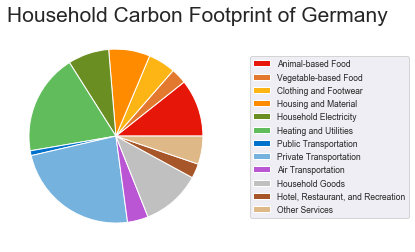

In [45]:
plt.pie(Footprint_Pie, startangle=90, colors = ["#E61709", "#E2792E", "#FDB515", "#FF8C00", "#6B8E23", "#61BD5C",
                                                "#0072CC", "#75B2DD", "#BA55D3", "#C0C0C0", "#A65628", "#DEB887"])
plt.legend(Parr, bbox_to_anchor=(1.2,0.5), loc="center right", fontsize=8.5,
           bbox_transform=plt.gcf().transFigure)
plt.title("Household Carbon Footprint of Germany", fontsize=21, loc='left')

# Additional Exercises

Calculating Household Carbon Footprint of China

In [46]:
Indirect_CN_HH = MRIO_Char[4,:].dot(MRIO_S).dot(MRIO_L).dot(np.diag(MRIO_Y[:,7*30]))

Indirect_CN_HH = Indirect_CN_HH.dot(Aggregation_Matrix_Cols.transpose())

Footprint_Carbon = Indirect_CN_HH.copy()

# Determine and add direct indicator:
Direct_GHG = MRIO_Char[4,:].dot(MRIO_FDE[:,7*30])
Direct_Housing_Carbon = Direct_GHG * (11/14)
Direct_Transport_Carbon = Direct_GHG * (3/14)

# Direct emissions breakdown is obtained here https://www.nature.com/articles/nclimate3165

Footprint_Carbon[3] = Footprint_Carbon[3] + Direct_Housing_Carbon
Footprint_Carbon[10] = Footprint_Carbon[10] + Direct_Transport_Carbon
                                
CF_PerCapita = Footprint_Carbon/Population[30]

pd.DataFrame(np.round(CF_PerCapita,2), index=Pa, columns=["kg CO2e"])

,kg CO2e
Air Transportation,7.36
Animal-based Food,291.28
Clothing and Footwear,117.66
Heating and Utilities,443.06
"Hotel, Restaurant, and Recreation",29.69
Household Electricity,416.45
Household Goods,236.19
Housing and Material,102.04
Other Services,288.44
Public Transportation,24.20


In [47]:
CF_PerCapita.sum(axis=0)

2326.815009598488

Calculating Household Carbon Footprint of France

In [34]:
Indirect_FR_HH = MRIO_Char[4,:].dot(MRIO_S).dot(MRIO_L).dot(np.diag(MRIO_Y[:,7*10]))

Indirect_FR_HH = Indirect_FR_HH.dot(Aggregation_Matrix_Cols.transpose())

Footprint_Carbon = Indirect_FR_HH.copy()

# Determine and add direct indicator:
Direct_GHG = MRIO_Char[4,:].dot(MRIO_FDE[:,7*10])
Direct_Housing_Carbon = Direct_GHG * GHGHeating[10]
Direct_Transport_Carbon = Direct_GHG * GHGTransport[10]
Direct_Others_Carbon = Direct_GHG * GHGOthers[10]

Footprint_Carbon[3] = Footprint_Carbon[3] + Direct_Housing_Carbon
Footprint_Carbon[10] = Footprint_Carbon[10] + Direct_Transport_Carbon
Footprint_Carbon[7] = Footprint_Carbon[7] + Direct_Others_Carbon
                                
CF_PerCapita = Footprint_Carbon/Population[10]

pd.DataFrame(np.round(CF_PerCapita,2), index=Pa, columns=["kg CO2e"])

,kg CO2e
Air Transportation,288.59
Animal-based Food,1091.16
Clothing and Footwear,354.70
Heating and Utilities,696.85
"Hotel, Restaurant, and Recreation",219.84
Household Electricity,231.45
Household Goods,735.19
Housing and Material,345.42
Other Services,211.43
Public Transportation,253.11


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: MatplotlibDeprecationWarning: Non-1D inputs to pie() are currently squeeze()d, but this behavior is deprecated since 3.1 and will be removed in 3.3; pass a 1D array instead.
  


Text(0.0, 1.0, 'Household Carbon Footprint of France')

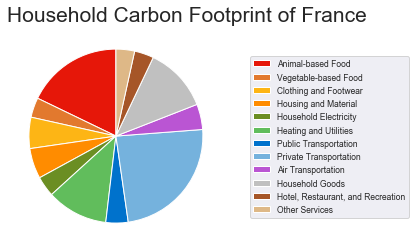

In [35]:
Footprint_Pie = pd.DataFrame(np.round(CF_PerCapita,2), index=Pa, columns=["kg CO2e per capita"])

Footprint_Pie = Footprint_Pie.reindex(Parr)

plt.pie(Footprint_Pie, startangle=90, colors = ["#E61709", "#E2792E", "#FDB515", "#FF8C00", "#6B8E23", "#61BD5C",
                                                "#0072CC", "#75B2DD", "#BA55D3", "#C0C0C0", "#A65628", "#DEB887"],)
plt.legend(Parr, bbox_to_anchor=(1.2,0.5), loc="center right", fontsize=8.5,
           bbox_transform=plt.gcf().transFigure)
plt.title("Household Carbon Footprint of France", fontsize=21, loc='left')

In [48]:
CF_PerCapita = np.zeros((12,28))

for n in range(0,28):
    Indirect_HH = MRIO_Char[4,:].dot(MRIO_S).dot(MRIO_L).dot(np.diag(MRIO_Y[:,7*n]))
    Indirect_HH = Indirect_HH.dot(Aggregation_Matrix_Cols.transpose())
    Footprint_Carbon = Indirect_HH.copy()

    # Determine and add direct indicator:
    Direct_GHG = MRIO_Char[4,:].dot(MRIO_FDE[:,7*n])
    Direct_Housing_Carbon = Direct_GHG * GHGHeating[n]
    Direct_Transport_Carbon = Direct_GHG * GHGTransport[n]
    Direct_Others_Carbon = Direct_GHG * GHGOthers[n]

    Footprint_Carbon[3] = Footprint_Carbon[3] + Direct_Housing_Carbon
    Footprint_Carbon[10] = Footprint_Carbon[10] + Direct_Transport_Carbon
    Footprint_Carbon[7] = Footprint_Carbon[7] + Direct_Others_Carbon
    
    CF_PerCapita[:,n] = Footprint_Carbon/Population[n]

pd.DataFrame(np.round(CF_PerCapita,2), index=Pa[0:12], columns=Region_Names[0:28])

,Austria,Belgium,Bulgaria,Cyprus,Czech Republic,Germany,Denmark,Estonia,Spain,Finland,...,Latvia,Malta,Netherlands,Poland,Portugal,Romania,Sweden,Slovenia,Slovakia,United Kingdom
Air Transportation,262.16,87.37,54.13,374.30,43.50,366.96,33.39,28.52,117.28,200.65,...,43.83,232.45,176.21,10.40,173.45,1.47,230.68,39.29,6.23,515.82
Animal-based Food,859.89,1308.63,424.88,757.86,746.52,1009.98,1595.89,1310.80,694.88,1079.05,...,797.40,680.01,1187.34,787.31,767.97,620.02,1014.13,751.13,614.16,885.16
Clothing and Footwear,456.46,464.31,171.71,142.68,148.66,481.25,406.86,279.35,310.41,410.39,...,166.40,302.59,337.84,134.96,274.96,76.56,374.45,246.49,271.89,512.42
Heating and Utilities,1619.51,1334.78,1544.98,310.99,4360.48,1772.83,796.44,1085.99,435.69,2221.22,...,331.02,37.86,1621.47,5193.56,34.86,941.63,984.34,828.86,2015.60,1777.95
"Hotel, Restaurant, and Recreation",512.34,419.49,114.96,633.75,366.07,256.08,467.00,410.34,407.62,496.80,...,233.81,284.20,313.98,100.68,309.60,40.70,368.90,384.69,286.87,261.94
Household Electricity,354.19,485.01,1883.55,1174.75,413.17,723.32,194.69,1746.18,282.75,1423.68,...,27.70,585.00,471.73,269.55,611.95,142.74,206.81,125.49,194.11,1667.73
Household Goods,842.85,1119.27,384.72,480.02,516.70,1045.44,862.17,509.25,483.75,1204.77,...,764.19,999.56,978.45,460.96,459.45,327.24,844.24,665.12,996.30,980.76
Housing and Material,686.23,631.59,482.55,467.77,689.57,725.76,779.25,526.64,286.97,791.32,...,765.73,481.10,527.76,468.06,540.81,317.59,568.27,366.83,551.53,415.72
Other Services,339.38,714.30,80.49,277.34,177.60,494.04,791.56,364.28,182.16,405.09,...,215.84,418.69,431.93,258.77,173.64,86.59,289.26,341.40,237.37,370.84
Public Transportation,181.72,52.09,70.54,2787.93,85.29,84.40,373.12,160.62,74.71,209.64,...,140.63,161.86,181.98,26.77,73.83,16.31,108.11,49.14,99.68,386.88


In [49]:
CF_PerCapita = np.append(CF_PerCapita, np.reshape(CF_PerCapita.sum(axis=0), (1,28)), axis=0)

Pa.append('Total')

EU28_CF = pd.DataFrame(np.round(CF_PerCapita,2), index=Pa, columns=Region_Names[0:28])

EU28_CF

,Austria,Belgium,Bulgaria,Cyprus,Czech Republic,Germany,Denmark,Estonia,Spain,Finland,...,Latvia,Malta,Netherlands,Poland,Portugal,Romania,Sweden,Slovenia,Slovakia,United Kingdom
Air Transportation,262.16,87.37,54.13,374.30,43.50,366.96,33.39,28.52,117.28,200.65,...,43.83,232.45,176.21,10.40,173.45,1.47,230.68,39.29,6.23,515.82
Animal-based Food,859.89,1308.63,424.88,757.86,746.52,1009.98,1595.89,1310.80,694.88,1079.05,...,797.40,680.01,1187.34,787.31,767.97,620.02,1014.13,751.13,614.16,885.16
Clothing and Footwear,456.46,464.31,171.71,142.68,148.66,481.25,406.86,279.35,310.41,410.39,...,166.40,302.59,337.84,134.96,274.96,76.56,374.45,246.49,271.89,512.42
Heating and Utilities,1619.51,1334.78,1544.98,310.99,4360.48,1772.83,796.44,1085.99,435.69,2221.22,...,331.02,37.86,1621.47,5193.56,34.86,941.63,984.34,828.86,2015.60,1777.95
"Hotel, Restaurant, and Recreation",512.34,419.49,114.96,633.75,366.07,256.08,467.00,410.34,407.62,496.80,...,233.81,284.20,313.98,100.68,309.60,40.70,368.90,384.69,286.87,261.94
Household Electricity,354.19,485.01,1883.55,1174.75,413.17,723.32,194.69,1746.18,282.75,1423.68,...,27.70,585.00,471.73,269.55,611.95,142.74,206.81,125.49,194.11,1667.73
Household Goods,842.85,1119.27,384.72,480.02,516.70,1045.44,862.17,509.25,483.75,1204.77,...,764.19,999.56,978.45,460.96,459.45,327.24,844.24,665.12,996.30,980.76
Housing and Material,686.23,631.59,482.55,467.77,689.57,725.76,779.25,526.64,286.97,791.32,...,765.73,481.10,527.76,468.06,540.81,317.59,568.27,366.83,551.53,415.72
Other Services,339.38,714.30,80.49,277.34,177.60,494.04,791.56,364.28,182.16,405.09,...,215.84,418.69,431.93,258.77,173.64,86.59,289.26,341.40,237.37,370.84
Public Transportation,181.72,52.09,70.54,2787.93,85.29,84.40,373.12,160.62,74.71,209.64,...,140.63,161.86,181.98,26.77,73.83,16.31,108.11,49.14,99.68,386.88


In [50]:
writer = pd.ExcelWriter(Path_Result + 'EU28_CarbonFootprint.xlsx', engine='xlsxwriter')

EU28_CF.to_excel(writer, sheet_name='Carbon Footprint')

# Close the Pandas Excel writer and output the Excel file.
writer.save()

# Changing the Final Demand Consumption to Observe Footprint Change

Final demand vector of German households will be decreased to the level of Czech households.

In [51]:
FD_DE_HH = MRIO_Y[:,EB3_NoofFDCategories*5]/Population[5]
FD_CZ_HH = MRIO_Y[:,EB3_NoofFDCategories*4]/Population[4]

Imp_DE_HH = np.reshape(FD_DE_HH, (49, 200))
Imp_CZ_HH = np.reshape(FD_CZ_HH, (49, 200))

AggFD_DE_HH = Imp_DE_HH.sum(axis=0)
AggFD_CZ_HH = Imp_CZ_HH.sum(axis=0)

NewAggFD_DE_HH = AggFD_CZ_HH.copy()
NewAggFD_DE_HH

array([8.28690043e-09, 3.77987854e-05, 1.06614853e-05, 8.96484448e-05,
       1.02787743e-05, 0.00000000e+00, 1.50505019e-06, 1.08520418e-05,
       0.00000000e+00, 0.00000000e+00, 2.29088819e-05, 1.01663083e-05,
       5.84059006e-06, 1.23230726e-05, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 6.19791431e-06, 3.58333818e-06, 0.00000000e+00,
       0.00000000e+00, 6.06179256e-06, 2.43212950e-11, 1.56124077e-13,
       4.60430675e-06, 4.59540431e-06, 9.61303858e-13, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 2.47096233e-05, 9.46272289e-05,
       7.23333253e-05, 9.80466981e-07, 1.03191441e-05, 2.29136353e-04,
       3.41471290e-06, 3.37138677e-05, 3.81909501e-04, 2.74279976e-05,
       1.83807963e-05, 4.05237112e-05, 7.41599816e-05, 5.71094821e-05,
      

In [52]:
NewAggFD_DE_HH.sum(axis=0)

0.006089109525269839

In [53]:
FD_CZ_HH.sum(axis=0)

0.006089109525269839

In [54]:
Heat_DE = np.reshape((np.diag(FD_DE_HH).dot(Aggregation_Matrix_Cols.transpose()))[:,3], (49,200)).sum(axis=0)
Trns_DE = np.reshape((np.diag(FD_DE_HH).dot(Aggregation_Matrix_Cols.transpose()))[:,10], (49,200)).sum(axis=0)

Heat_CZ = np.reshape((np.diag(FD_CZ_HH).dot(Aggregation_Matrix_Cols.transpose()))[:,3], (49,200)).sum(axis=0)
Trns_CZ = np.reshape((np.diag(FD_CZ_HH).dot(Aggregation_Matrix_Cols.transpose()))[:,10], (49,200)).sum(axis=0)

HeatFuel_DE = Heat_DE.sum(axis=0)
TrnsFuel_DE = Trns_DE.sum(axis=0) - Trns_DE[122:124].sum(axis=0) - Trns_DE[151:153].sum(axis=0)

HeatFuel_CZ = Heat_CZ.sum(axis=0)
TrnsFuel_CZ = Trns_CZ.sum(axis=0) - Trns_CZ[122:124].sum(axis=0) - Trns_CZ[151:153].sum(axis=0)

In [58]:
Elec_DE = np.diag(FD_DE_HH).dot(Aggregation_Matrix_Cols.transpose())[5*200+127:5*200+141,5]
Wste_DE = np.diag(FD_DE_HH).dot(Aggregation_Matrix_Cols.transpose())[5*200+175:5*200+195,7]

NewFD_DE_HH = NewAggFD_DE_HH * np.nan_to_num(Imp_DE_HH/Imp_DE_HH.sum(axis=0))
NewFD_DE_HH[5,127:141] = Elec_DE/Elec_DE.sum(axis=0) * NewFD_DE_HH[5,127:141].sum(axis=0)
NewFD_DE_HH[5,175:195] = Wste_DE/Wste_DE.sum(axis=0) * NewFD_DE_HH[5,175:195].sum(axis=0)

NewFD_DE_HH = np.reshape(NewFD_DE_HH, (9800))

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in true_divide
  after removing the cwd from sys.path.


In [59]:
Indirect_DE_HH = MRIO_Char[4,:].dot(MRIO_S).dot(MRIO_L).dot(np.diag(NewFD_DE_HH))

Indirect_DE_HH = Indirect_DE_HH.dot(Aggregation_Matrix_Cols.transpose())

Footprint_Carbon = Indirect_DE_HH.copy()

# Determine and add direct indicator:
Direct_GHG = MRIO_Char[4,:].dot(MRIO_FDE[:,7*5])
Direct_Housing_Carbon = HeatFuel_CZ / HeatFuel_DE * Direct_GHG * GHGHeating[5]/Population[5]
Direct_Transport_Carbon = TrnsFuel_CZ / TrnsFuel_DE * Direct_GHG * GHGTransport[5]/Population[5]
Direct_Others_Carbon = Direct_GHG * GHGOthers[5]/Population[5]

Footprint_Carbon[3] = Footprint_Carbon[3] + Direct_Housing_Carbon
Footprint_Carbon[10] = Footprint_Carbon[10] + Direct_Transport_Carbon
Footprint_Carbon[7] = Footprint_Carbon[7] + Direct_Others_Carbon

Footprint_Carbon = np.append(Footprint_Carbon, Footprint_Carbon.sum(axis=0))
pd.DataFrame(np.round(Footprint_Carbon,2), index=Pa, columns=["kg CO2e"])

,kg CO2e
Air Transportation,34.33
Animal-based Food,657.14
Clothing and Footwear,154.05
Heating and Utilities,2817.25
"Hotel, Restaurant, and Recreation",146.51
Household Electricity,706.61
Household Goods,413.24
Housing and Material,259.71
Other Services,110.86
Public Transportation,21.15


# What will happen if German households consume like...

Simulating the carbon footprint of German households when their final demand vector is decreased to the level of households in other countries.

In [60]:
ModelFprint = np.zeros((49,12))

OC = 5 #Origin Country

FD_OC_HH = MRIO_Y[:,EB3_NoofFDCategories*OC]/Population[OC]
Imp_OC_HH = np.reshape(FD_OC_HH, (49, 200))
AggFD_OC_HH = Imp_OC_HH.sum(axis=0)

Heat_OC = np.reshape((np.diag(FD_OC_HH).dot(Aggregation_Matrix_Cols.transpose()))[:,3], (49,200)).sum(axis=0)
Trns_OC = np.reshape((np.diag(FD_OC_HH).dot(Aggregation_Matrix_Cols.transpose()))[:,10], (49,200)).sum(axis=0)

HeatFuel_OC = Heat_OC.sum(axis=0) #- Heat_OC[146:149].sum(axis=0)
TrnsFuel_OC = Trns_OC.sum(axis=0) - Trns_OC[122:124].sum(axis=0) - Trns_OC[151:153].sum(axis=0)

Elec_OC = np.diag(FD_OC_HH).dot(Aggregation_Matrix_Cols.transpose())[OC*200+127:OC*200+141,5]
Wste_OC = np.diag(FD_OC_HH).dot(Aggregation_Matrix_Cols.transpose())[OC*200+175:OC*200+195,7]
    
for i in range(0,49):
    FD_MC_HH = MRIO_Y[:,EB3_NoofFDCategories*i]/Population[i]
    Imp_MC_HH = np.reshape(FD_MC_HH, (49, 200))
    AggFD_MC_HH = Imp_MC_HH.sum(axis=0)
    NewAggFD_OC_HH = AggFD_MC_HH.copy()

    Heat_MC = np.reshape((np.diag(FD_MC_HH).dot(Aggregation_Matrix_Cols.transpose()))[:,3], (49,200)).sum(axis=0)
    Trns_MC = np.reshape((np.diag(FD_MC_HH).dot(Aggregation_Matrix_Cols.transpose()))[:,10], (49,200)).sum(axis=0)

    HeatFuel_MC = Heat_MC.sum(axis=0) #- Heat_MC[146:149].sum(axis=0)
    TrnsFuel_MC = Trns_MC.sum(axis=0) - Trns_MC[122:124].sum(axis=0) - Trns_MC[151:153].sum(axis=0)
    
    NewFD_OC_HH = NewAggFD_OC_HH * np.nan_to_num(Imp_OC_HH/Imp_OC_HH.sum(axis=0))
    NewFD_OC_HH[OC,127:141] = Elec_OC/Elec_OC.sum(axis=0) * NewFD_OC_HH[OC,127:141].sum(axis=0)
    NewFD_OC_HH[OC,175:195] = Wste_OC/Wste_OC.sum(axis=0) * NewFD_OC_HH[OC,175:195].sum(axis=0)

    NewFD_OC_HH = np.reshape(NewFD_OC_HH, (9800))

    Indirect_OC_HH = MRIO_Char[4,:].dot(MRIO_S).dot(MRIO_L).dot(np.diag(NewFD_OC_HH))

    Indirect_OC_HH = Indirect_OC_HH.dot(Aggregation_Matrix_Cols.transpose())

    ModelFprint[i,:] = Indirect_OC_HH.copy()

    # Determine and add direct indicator:
    Direct_GHG = MRIO_Char[4,:].dot(MRIO_FDE[:,7*OC])
    Direct_Housing_Carbon = HeatFuel_MC / HeatFuel_OC * Direct_GHG * GHGHeating[OC]/Population[OC]
    Direct_Transport_Carbon = TrnsFuel_MC / TrnsFuel_OC * Direct_GHG * GHGTransport[OC]/Population[OC]
    Direct_Others_Carbon = Direct_GHG * GHGOthers[OC]/Population[OC]

    ModelFprint[i,3] = ModelFprint[i,3] + Direct_Housing_Carbon
    ModelFprint[i,10] = ModelFprint[i,10] + Direct_Transport_Carbon
    ModelFprint[i,7] = ModelFprint[i,7] + Direct_Others_Carbon


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: invalid value encountered in true_divide


In [61]:
ModelFprint = np.append(ModelFprint, np.reshape(ModelFprint.sum(axis=1), (49, 1)), axis=1)
Model_CF = pd.DataFrame(np.round(ModelFprint.transpose(),2), index=Pa, columns=Region_Names)

Model_CF

,Austria,Belgium,Bulgaria,Cyprus,Czech Republic,Germany,Denmark,Estonia,Spain,Finland,...,Turkey,Taiwan,Norway,Indonesia,South Africa,RoW Asia and Pacific,RoW America,RoW Europe,RoW Africa,RoW Middle East
Air Transportation,258.73,80.09,47.98,328.76,34.33,366.96,40.15,23.03,91.96,159.49,...,66.01,246.52,378.24,7.24,26.14,13.96,50.15,22.14,8.89,38.07
Animal-based Food,989.67,1242.08,395.60,623.80,657.14,1009.98,1540.73,885.79,767.45,1504.28,...,437.80,465.63,1354.95,171.92,223.11,97.12,308.17,139.55,61.97,222.03
Clothing and Footwear,535.34,475.78,116.45,139.31,154.05,481.25,491.66,311.11,338.95,431.98,...,503.43,148.77,623.72,40.50,96.46,46.32,129.48,76.60,25.43,110.98
Heating and Utilities,1682.48,1446.00,357.50,217.29,2817.25,1772.83,1412.64,3491.50,717.08,621.35,...,588.64,257.29,1861.33,48.55,71.78,89.24,226.14,129.90,51.41,198.91
"Hotel, Restaurant, and Recreation",495.46,251.87,63.05,265.03,146.51,256.08,334.23,94.82,402.60,368.35,...,71.20,146.61,501.55,41.76,14.17,24.74,79.48,34.47,12.94,48.09
Household Electricity,1164.23,1019.05,156.10,730.02,706.61,723.32,1420.12,448.20,559.02,903.17,...,226.65,238.72,2169.44,14.72,16.98,54.42,118.10,83.67,35.35,152.15
Household Goods,910.08,967.84,235.73,282.66,413.24,1045.44,1056.38,385.81,424.17,1124.73,...,174.41,520.77,1381.90,110.35,160.02,136.26,282.65,117.27,36.09,155.48
Housing and Material,646.00,513.26,116.18,444.78,259.71,725.76,934.79,185.87,416.91,705.80,...,197.04,177.76,786.37,65.73,95.03,52.42,130.33,77.20,37.51,97.92
Other Services,415.33,501.08,57.97,266.20,110.86,494.04,622.92,113.30,239.13,365.70,...,77.86,234.34,541.47,13.10,106.51,45.74,147.67,68.00,21.31,91.63
Public Transportation,91.38,22.17,24.87,1228.34,21.15,84.40,172.93,108.66,69.42,238.95,...,84.20,78.11,1172.71,19.87,24.05,4.50,25.32,10.97,1.73,20.88


In [62]:
writer = pd.ExcelWriter(Path_Result + 'Modelled_CarbonFprintDE.xlsx', engine='xlsxwriter')

Model_CF.to_excel(writer, sheet_name='Carbon Footprint')

# Close the Pandas Excel writer and output the Excel file.
writer.save()

# Discussion

How valid is this Carbon Footprint scenario modelling?

- Geographical Constraints for Heating Demand
- Purchasing Power Parity
- Estimation Method of Direct Emissions 
- ...

In [63]:
print('Script is finished. Terminating logging process and closing all log files.')
Time_End = time.time()
Time_Duration = Time_End - Time_Start

print('End of simulation: ' + time.asctime() + '.')
print('Duration of simulation: %.1f seconds.' % Time_Duration)

Script is finished. Terminating logging process and closing all log files.
End of simulation: Tue Feb  4 12:22:53 2020.
Duration of simulation: 10963.8 seconds.
